## REDICTING HOUSE PRICES USING RANDOM FOREST

This model was created using Dataquest Webinar: https://www.youtube.com/watch?v=IsoW7_X3j5A as an attendee. All other anotations are mine.

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree (Yiu, 2019).

Datasets:

- 'RRVRUSQ156N.csv' : Reantal vacancy Rate
- 'CPIAUCSL.csv' : US CPI (Inflation measure)
- 'MORTGAGE30US.csv' : mortage interest rates, weekly
- 'Metro_median_sale_price_uc_sfrcondo_week.csv' : median sale price for US houses
- 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv' : zillow home value index


<img src="random-forest.png" alt="Drawing" style="width: 500px;"/>


### 1. Entering data and Cleaning

In [1]:
import pandas as pd

#List comprenhension 
fed_files = ['RRVRUSQ156N.csv','CPIAUCSL.csv','MORTGAGE30US.csv'] 
dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]


#parse_dates=True transforms any dates it founds into date format
#index_col=0 uses the first column for the row indexes

In [2]:
fed_data = pd.concat(dfs,axis=1)

#concatenates the data along the columns instead of the indexes

In [3]:
#.tail used to show the bottom N
fed_data.tail(15)


#RRVRUSQ156N released quarterly
#MORTGAGE30US released monthly
#CPIAUCSL released weekly

,RRVRUSQ156N,CPIAUCSL,MORTGAGE30US
DATE,,,
2022-05-19,NaN,NaN,5.25
2022-05-26,NaN,NaN,5.10
2022-06-01,NaN,295.328,NaN
2022-06-02,NaN,NaN,5.09
2022-06-09,NaN,NaN,5.23
2022-06-16,NaN,NaN,5.78
2022-06-23,NaN,NaN,5.81
2022-06-30,NaN,NaN,5.70
2022-07-01,NaN,295.271,NaN


In [4]:
# We have NAN values, the data is going to remain constant during the period until the next value shows up.

In [5]:
fed_data = fed_data.ffill()
fed_data.tail(15)

# ffill is forward fill in pandas, so fills anything until it has a new value, works for timeseries data.

,RRVRUSQ156N,CPIAUCSL,MORTGAGE30US
DATE,,,
2022-05-19,5.6,291.474,5.25
2022-05-26,5.6,291.474,5.10
2022-06-01,5.6,295.328,5.10
2022-06-02,5.6,295.328,5.09
2022-06-09,5.6,295.328,5.23
2022-06-16,5.6,295.328,5.78
2022-06-23,5.6,295.328,5.81
2022-06-30,5.6,295.328,5.70
2022-07-01,5.6,295.271,5.70


In [6]:
#List comprenhension
zillow_files = ['Metro_median_sale_price_uc_sfrcondo_week.csv','Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv']
dfs = [pd.read_csv(f) for f in zillow_files]
dfs[0]

#dfs[0] shows the first dataset.

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-02,2008-02-09,2008-02-16,2008-02-23,2008-03-01,...,2022-05-07,2022-05-14,2022-05-21,2022-05-28,2022-06-04,2022-06-11,2022-06-18,2022-06-25,2022-07-02,2022-07-09
0,102001,0,United States,Country,NaN,190000.0,190000.0,193000.0,189900.0,194900.0,...,369900.0,370000.0,370000.0,375000.0,375000.0,370000.0,375000.0,370000.0,370000.0,362500.0
1,394913,1,"New York, NY",Msa,NY,400000.0,418250.0,420000.0,420000.0,400000.0,...,550000.0,555000.0,550000.0,575000.0,575000.0,578000.0,590000.0,582000.0,585000.0,595000.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,497500.0,515000.0,520000.0,525000.0,498250.0,...,914000.0,925000.0,925000.0,951000.0,950000.0,920500.0,925000.0,900000.0,900500.0,906000.0
3,394463,3,"Chicago, IL",Msa,IL,245000.0,245000.0,251000.0,255000.0,255000.0,...,315000.0,310000.0,315500.0,315000.0,330000.0,324950.0,335000.0,325000.0,325000.0,315000.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,144250.0,148900.0,139000.0,143700.0,145900.0,...,422000.0,430000.0,430000.0,425000.0,440000.0,425000.0,427750.0,426000.0,420000.0,420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,394528,90,"Daytona Beach, FL",Msa,FL,NaN,170000.0,182400.0,170000.0,170000.0,...,340500.0,345000.0,327700.0,345000.0,350000.0,343250.0,359900.0,352000.0,336000.0,342990.0
80,394531,91,"Des Moines, IA",Msa,IA,138000.0,160000.0,150000.0,151750.0,154500.0,...,270000.0,285250.0,295000.0,273450.0,301000.0,290000.0,300900.0,281900.0,289250.0,280000.0
81,395006,100,"Provo, UT",Msa,UT,NaN,206000.0,215500.0,210000.0,210000.0,...,527000.0,540000.0,535000.0,552500.0,543750.0,571000.0,530300.0,569900.0,539950.0,572500.0
82,394549,104,"Durham, NC",Msa,NC,210000.0,170000.0,170500.0,197500.0,180000.0,...,456000.0,450000.0,428500.0,480000.0,465000.0,440000.0,450250.0,416000.0,465000.0,435250.0


In [7]:
#We are going to use the row for United States to make our analysis, that can be chanted easily 

In [8]:
#df.iloc locates rows by position
dfs = [pd.DataFrame(df.iloc[0,5:]) for df in dfs]
for df in dfs:
    df.index = pd.to_datetime(df.index)
    df["month"] = df.index.to_period("M")
    

# iloc can be read, take the first row(0) and then from column 5 until the end of the document for both dfs.
# Change the month to show the data for the month.

In [9]:
price_data = dfs[0].merge(dfs[1], on="month")
price_data.index = dfs[0].index

price_data
# 0_x avg sales price for each house
# 0_y avg value of the house


#This is a left join, done on month, anything that doesn't match is lost and the x value are then

,0_x,month,0_y
2008-02-02,190000.0,2008-02,206885.853266
2008-02-09,190000.0,2008-02,206885.853266
2008-02-16,193000.0,2008-02,206885.853266
2008-02-23,189900.0,2008-02,206885.853266
2008-03-01,194900.0,2008-03,205459.521952
...,...,...,...
2022-06-11,370000.0,2022-06,357473.327397
2022-06-18,375000.0,2022-06,357473.327397
2022-06-25,370000.0,2022-06,357473.327397
2022-07-02,370000.0,2022-07,357107.271636


In [10]:
del price_data["month"]
price_data.columns = ["price","value"]

#deletes the month column and sets the column names.

In [11]:
fed_data = fed_data.dropna()
fed_data.tail(10)

,RRVRUSQ156N,CPIAUCSL,MORTGAGE30US
DATE,,,
2022-06-16,5.6,295.328,5.78
2022-06-23,5.6,295.328,5.81
2022-06-30,5.6,295.328,5.70
2022-07-01,5.6,295.271,5.70
2022-07-07,5.6,295.271,5.30
2022-07-14,5.6,295.271,5.51
2022-07-21,5.6,295.271,5.54
2022-07-28,5.6,295.271,5.30
2022-08-04,5.6,295.271,4.99


In [12]:
# fed data releases the dates two days before zillow data, so the we need to align the datasets

DateTime library: https://docs.python.org/3/library/datetime.html#timedelta-objects

In [13]:
from datetime import timedelta #https://docs.python.org/3/library/datetime.html#timedelta-objects

fed_data.index = fed_data.index + timedelta(days = 2)

In [14]:
fed_data

,RRVRUSQ156N,CPIAUCSL,MORTGAGE30US
DATE,,,
1971-04-04,5.3,40.100,7.33
1971-04-11,5.3,40.100,7.31
1971-04-18,5.3,40.100,7.31
1971-04-25,5.3,40.100,7.31
1971-05-02,5.3,40.100,7.29
...,...,...,...
2022-07-16,5.6,295.271,5.51
2022-07-23,5.6,295.271,5.54
2022-07-30,5.6,295.271,5.30


In [15]:
price_data = fed_data.merge(price_data, left_index = True, right_index = True)
price_data.columns = ['interest', 'cpi', 'vacancy', 'price', 'value']

price_data

,RRVRUSQ156N,CPIAUCSL,MORTGAGE30US,price,value
2008-02-02,10.1,212.174,5.68,190000.0,206885.853266
2008-02-09,10.1,212.687,5.67,190000.0,206885.853266
2008-02-16,10.1,212.687,5.72,193000.0,206885.853266
2008-02-23,10.1,212.687,6.04,189900.0,206885.853266
2008-03-01,10.1,212.687,6.24,194900.0,205459.521952
...,...,...,...,...,...
2022-06-11,5.6,295.328,5.23,370000.0,357473.327397
2022-06-18,5.6,295.328,5.78,375000.0,357473.327397
2022-06-25,5.6,295.328,5.81,370000.0,357473.327397
2022-07-02,5.6,295.328,5.70,370000.0,357107.271636


### 2. Setting up Machine Learning Target

<AxesSubplot:>

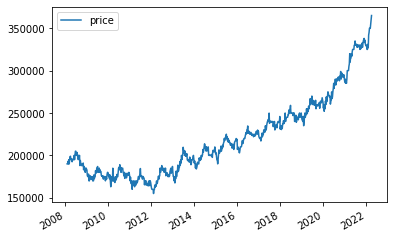

In [47]:
price_data.plot.line(y='price',use_index = True)


#This dashboard line includes data that has inflation, for the model we are not going to use it.

In [48]:
# We just want to predict prices without inflation
price_data["adj_price"] = price_data['price']/price_data['cpi']*100
price_data["adj_value"] = price_data['value']/price_data['cpi']*100
price_data['next quarter'] = price_data['adj_price'].shift(-13)


#it uses shifts as the data goes by weekly, 13 weeks would mean the next quarter.

<AxesSubplot:>

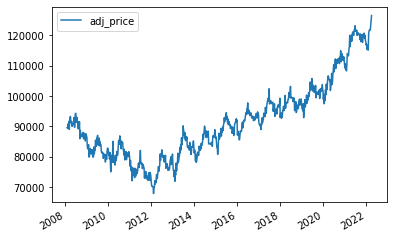

In [49]:
# we multiply because CPI is in units of 100
price_data["adj_price"]
price_data.plot.line(y='adj_price',use_index = True)

In [22]:
price_data

,interest,cpi,vacancy,price,value,adj_price,adj_value,next quarter
2008-02-02,10.1,212.174,5.68,190000.0,206885.853266,89549.143627,97507.636782,90610.014498
2008-02-09,10.1,212.687,5.67,190000.0,206885.853266,89333.151533,97272.448841,90563.547824
2008-02-16,10.1,212.687,5.72,193000.0,206885.853266,90743.674978,97272.448841,91014.739229
2008-02-23,10.1,212.687,6.04,189900.0,206885.853266,89286.134084,97272.448841,90610.014498
2008-03-01,10.1,212.687,6.24,194900.0,205459.521952,91637.006493,96601.824254,92933.348203
...,...,...,...,...,...,...,...,...
2022-06-11,5.6,295.328,5.23,370000.0,357473.327397,125284.429516,121042.815919,NaN
2022-06-18,5.6,295.328,5.78,375000.0,357473.327397,126977.462347,121042.815919,NaN
2022-06-25,5.6,295.328,5.81,370000.0,357473.327397,125284.429516,121042.815919,NaN
2022-07-02,5.6,295.328,5.70,370000.0,357107.271636,125284.429516,120918.867035,NaN


In [23]:
price_data.dropna(inplace=True)
price_data["change"] = (price_data["next quarter"] > price_data["adj_price"]).astype(int)

price_data


#creates indicator to tell if there will there be an increase in the price of the house.

In [27]:
price_data["change"].value_counts()


#they are pretty balanced so we can include them in our machine learning model as targets

1    379
0    343
Name: change, dtype: int64

### 2. Creating a Machine Learning model

In [ ]:
predictors = ["interest", "vacancy", "adj_price", "adj_value"]
target = ["change"]

In [30]:
#Random Forest
# Work pretty well, robust to overfitting, pick ups no linear tendencies in the data.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np #pandas uses numpy under the hood

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

START = 260
STEP = 52

def predict(train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split=10, random_state=1)
    rf.fit(train[predictors], np.ravel(train[target]))
    preds = rf.predict(test[predictors])
    return preds

def backtest(data, predictors, target):
    all_preds = []
    for i in range(START, data.shape[0], STEP):
        train = price_data.iloc[:i] #takes everything below i
        test = price_data.iloc[i:(i+STEP)] #takes everything after i
        all_preds.append(predict(train, test, predictors, target)) #this creates a list of lists
    
    preds = np.concatenate(all_preds)
    #Accuracy predicts actual to predicted values
    return preds, accuracy_score(data.iloc[START:][target], preds)

#Random Forest Arguments: 
## min_samples_split prevents the nodes of the random forest to sink to deeply
## Random_state=1 it uses randomization internally, when set you'll get similar results if you run the algorithm twice

#np.ravel() it returns a flattened array.

### 3.Creating a backtesting engine

A backtesting engine respects the order of the data. If we were to use crossvalidation with time series data we do not want our data predicting info from the past, you'll end up using data from 2022 to predict what happened in 2019, where the effectivity of the model should be predicting the future.

In [55]:
preds, accuracy = backtest(price_data, predictors, target)

In [51]:
accuracy

0.5822510822510822

### 4. Improving our Model
lets have a couple more information in the ML model

In [58]:
yearly = price_data.rolling(52, min_periods=1).mean() 
#yearly

#FACT: if pandas has 52 rows of data upwards pandas will return an NA, this is a rolling average

,interest,cpi,vacancy,price,value,adj_price,adj_value,next quarter,change,interest_year,vacancy_year,adj_price_year,adj_value_year
2008-02-02,10.100000,212.174000,5.680000,190000.000000,206885.853266,89549.143627,97507.636782,90610.014498,1.000000,1.000000,1.000000,1.000000,1.000000
2008-02-09,10.100000,212.430500,5.675000,190000.000000,206885.853266,89441.147580,97390.042811,90586.781161,1.000000,1.000000,0.999559,0.999396,0.999396
2008-02-16,10.100000,212.516000,5.690000,191000.000000,206885.853266,89875.323379,97350.844821,90729.433850,1.000000,1.000000,1.001464,1.002818,0.999329
2008-02-23,10.100000,212.558750,5.777500,190725.000000,206885.853266,89728.026056,97331.245826,90699.579012,1.000000,1.000000,1.012457,1.000882,0.999346
2008-03-01,10.100000,212.584400,5.870000,191560.000000,206600.587003,90109.822143,97185.361512,91146.332850,1.000000,1.000000,1.022572,1.004096,0.998276
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,5.934615,274.619904,3.115000,327174.057692,313200.591987,119132.562983,113969.580920,120036.171851,0.576923,0.945879,1.059264,1.036889,1.057890
2022-03-19,5.915385,275.056058,3.136923,328135.596154,314338.764087,119295.169360,114202.242187,120038.316026,0.576923,0.944091,1.065335,1.036580,1.057792
2022-03-26,5.896154,275.492212,3.163269,329193.288462,315476.936188,119491.196374,114434.903454,120040.564794,0.576923,0.942377,1.072552,1.036558,1.057687
2022-04-02,5.876923,275.928365,3.193654,330250.980769,316739.596917,119684.363389,114710.833809,119996.792879,0.576923,0.940737,1.080725,1.036496,1.057945


In [60]:
#List comprehension creates list and then assigns the name to the data.

yearly_ratios = [p + "_year" for p in predictors] 
price_data[yearly_ratios] = price_data[predictors] / yearly[predictors] 

#price_data

,interest,cpi,vacancy,price,value,adj_price,adj_value,next quarter,change,interest_year,vacancy_year,adj_price_year,adj_value_year
2008-02-02,10.1,212.174,5.68,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1,1.000000,1.000000,1.0,1.0
2008-02-09,10.1,212.687,5.67,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,1,1.000000,0.999119,0.998793,0.998793
2008-02-16,10.1,212.687,5.72,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1,1.000000,1.005272,1.009662,0.999195
2008-02-23,10.1,212.687,6.04,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1,1.000000,1.045435,0.995075,0.999396
2008-03-01,10.1,212.687,6.24,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1,1.000000,1.063032,1.016948,0.993996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,5.8,287.708,3.85,350000.0,344042.433111,121651.118495,119580.419422,NaN,1,0.977317,1.235955,1.021141,1.049231
2022-03-19,5.8,287.708,4.16,350000.0,344042.433111,121651.118495,119580.419422,NaN,1,0.980494,1.326140,1.019749,1.047093
2022-03-26,5.8,287.708,4.42,355000.0,344042.433111,123388.991617,119580.419422,NaN,1,0.983692,1.397289,1.03262,1.044965
2022-04-02,5.8,287.708,4.67,360000.0,350515.841789,125126.864738,121830.412011,NaN,1,0.986911,1.462275,1.045474,1.062065


In [61]:
preds, accuracy = backtest(price_data, predictors + yearly_ratios, target)


#To add additional predictors use +

In [62]:
accuracy

0.645021645021645

### 3.Diagnosis

In [57]:
pred_match = (preds == np.ravel(price_data[target].iloc[START:]))
pred_match = pred_match.astype(str)


#comparing the predicted values to the actuals values, will 
#will be true when the preds align.

In [42]:
pred_match

array(['True', 'True', 'True', 'True', 'True', 'True', 'True', 'True',
       'False', 'False', 'False', 'False', 'True', 'True', 'True', 'True',
       'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True',
       'True', 'False', 'False', 'True', 'True', 'True', 'True', 'True',
       'True', 'True', 'False', 'False', 'True', 'True', 'True', 'True',
       'False', 'True', 'False', 'True', 'True', 'True', 'True', 'True',
       'True', 'True', 'True', 'True', 'True', 'True', 'False', 'True',
       'False', 'False', 'False', 'False', 'False', 'False', 'False',
       'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True',
       'True', 'True', 'True', 'False', 'True', 'False', 'False', 'False',
       'False', 'False', 'True', 'True', 'True', 'True', 'False', 'False',
       'True', 'True', 'False', 'True', 'False', 'False', 'False',
       'False', 'False', 'True', 'False', 'False', 'False', 'False',
       'False', 'False', 'False', 'True', 'True', 'True', 'True',

In [43]:
pred_match[pred_match=='True']='Green'
pred_match[pred_match=='False']='Red'

<AxesSubplot:xlabel='index', ylabel='adj_price'>

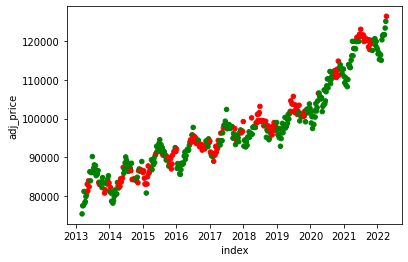

In [44]:
import matplotlib.pyplot as plt


plot_data = price_data.iloc[START:].copy()
plot_data.reset_index().plot.scatter(x="index", y="adj_price", color=pred_match)


# plot_data.reset_index() has to be used to use the index in the plot

The model shows <b>lack</b> of understanding when the market sinks or suddenly increases. Additional data could be able to predict those values.

### 5. Final Feature Engineering

Check whether the columns are important for the model

In [67]:
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(min_samples_split=10, random_state=1)
rf.fit(price_data[predictors], np.ravel(price_data[target]))

result = permutation_importance(rf, price_data[predictors], price_data[target], n_repeats=10, random_state=1)

In [68]:
result["importances_mean"]


#Gives us the important of the varibles the higher the value the more important is the value

array([0.16772853, 0.14639889, 0.27977839, 0.34944598])